# 동아대학교 컴퓨터AI공학부
## CSE408: 빅데이터 분석


이번 프로그램에서는 Colab환경에서 로컬모드로 [Apache Spark](https://spark.apache.org)을 사용하는 방법을 배웁니다.

Credits 은 천세진(sjchun@dau.ac.kr)에 있습니다

# 목적: 본 자료는 빅데이터분석의 수업진행을 위한 기초 부분입니다. 
해당 예제를 통해서 여러분과 관련된 다양한 형태로 변화/발전 시키는 것이 매우 중요합니다.

1. 목적에 따라 데이터를 변경하실줄 알아야합니다. 예를 들어, 버스정류장 주소 대신에 전기차 충전소 주소를 변경하여 사용할줄 알아야합니다.

2. 또한, 데이터를 적절하게 가공/변환하는 능력이 필요합니다. 여러분이 제공받는 데이터는 구체적이지 못할수도 있습니다. 예를 들면, 3개월치 데이터의 평균 이나 구 단위의 주소 정보 등이 될수 있습니다. 

3. 어떠한 문제해결 하고자  혹은 어떠한 영향/관계가 있는지 등 다양한 파악하는 능력이 프로젝트의 수행범위를 최소화하는데 큰 도움을 줍니다. 예를 들면, 내가 어떠한 입력을 받아서 어떠한 출력을 얻을려는가? 예로, 버스정류장 정류소의 위경도 자료를 받아서 버스 정류장을 지도에 배치 하는것?

4. 고급 방법(연구나 창업, 경진대회)에 접근하기 위해서는, 해당 문제 해결을 위한 기본 메서드(baseline methods라고 함) 혹은 최신의 방법은 무엇이 있는지를 파악해야합니다. 인터넷검색, 블로그보다는 논문을 통해서 자료를 얻는 것이 제일 구체화되고 정확하며, 최신 접근법을 획득할 수 있습니다. 




# Setup
아래 Colab 코드를 실행하여 pySpark를 설치합니다. 현재 프로그램을 수행할때마다 pySpark를 설치해야합니다. 추후에는 pySpark를 여러분의 구글 드라이브에 설치하여  설치시간을 최소할 할 것입니다.

In [1]:
!pip install -U -q PyDrive

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# 공유된 구글 파일을 리스트를 가져옵니다  
# https://drive.google.com/drive/folders/1-EJr-anFISoVb96QYedLx5PklEtm9JSu?usp=sharing
id='1-EJr-anFISoVb96QYedLx5PklEtm9JSu'
file_list = drive.ListFile({'q': f"'{id}' in parents and trashed=false"}).GetList()

In [4]:
# 공유된 파일리스트 확인하고 데이터를 다운로드 받습니다.
for file in file_list:
  downloaded = drive.CreateFile({'id': file['id']}) 
  downloaded.GetContentFile(file['title'])  
  print(file['title'])

SBJ_2107_003.zip
DAU_CSE408_Colab_02_(PySpark_Complete).ipynb


In [5]:
!unzip SBJ_2107_003.zip

Archive:  SBJ_2107_003.zip
  inflating: 10.부산시남구_공시지가.geojson  
  inflating: 11.부산시남구_도로명주소(도로).geojson  
  inflating: 12.부산시남구_토지이용현황.geojson  
  inflating: 13.부산시남구_토지이용현황(코드).csv  
  inflating: 14.부산시남구_행정경계(읍면동).geojson  
  inflating: 15.부산시남구_격자(300X300).geojson  
  inflating: 16.코드정의서.xlsx  
  inflating: 4.부산시남구_건축물대장(표제부).csv  
  inflating: 5.부산시남구_도로명주소(건물).geojson  
  inflating: 6.부산시_남구_주택노후도.geojson  
  inflating: 7.부산시남구_버스정류소정보.csv  
  inflating: 8.부산시남구_지하철역정보.csv  
  inflating: 9.부산시남구_동별_인구정보.csv  


위의 코드가 정상적으로 실행되었다면, 좌측 다운로드 폴더아이콘 탭에 파일이 정상적으로 다운로드 된것을 확인할 수 있습니다.

In [6]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터 알아보기

[COMPAS](https://compas.lh.or.kr/)는 도시문제 해결의 방향성을 제시하는 한국토지주택공사 데이터 분석 플랫폼입니다. 

교통, 화재 예측, 도시환경, 트래픽, 신호등  체계, 버스노선, 미세먼지, 도시녹지, 교통사고예방, 횡단보도 신호체계, 어린이보호구역 사고 예측, 불법 주정차 단속 카메라 설치 위치 분석 에 대한 주제로 진행합니다.


언급한 주제에 대한 분석과제는 최적의 위치선정, 특정 값에 대한 예측 등이 기술 개발이 이룹니다. 따라서, 해당 기술들이 기준선(baseline) 메소드가 무엇이 있는지 확인하고 접근하는 것이 매우 중요합니다

아래 코드 셀은 버스 정류소 정보를 가져와서 지도에 배치하는 작업을 다룹니다

In [7]:
# csv 파일을 읽기
BusStops = pd.read_csv('7.부산시남구_버스정류소정보.csv')

In [8]:
# 데이터타입 재확인
BusStops.dtypes

stn_no      float64
stn_id        int64
stn_nm       object
lon         float64
lat         float64
stn_info     object
dtype: object

In [9]:
# 3줄만 출력하기
BusStops.head(10)

,stn_no,stn_id,stn_nm,lon,lat,stn_info
0,7002.0,180710101,동부변전소,129.094314,35.147485,일반
1,7003.0,180720201,성모병원대남초등학교입구,129.095258,35.147608,일반
2,7004.0,180790101,낙농마을,129.098048,35.145072,일반
3,7005.0,199490101,대남교차로,129.104207,35.140628,일반
4,7006.0,199480301,경성대 부경대역,129.102307,35.138561,일반
5,7007.0,180870101,경성대 부경대역,129.102110,35.138205,일반
6,7008.0,181570301,부산성모병원,129.111037,35.112065,일반
7,7009.0,180390302,경성대학교입구,129.100537,35.136332,일반
8,7010.0,180750201,경성대학교입구,129.100592,35.136423,일반
9,7011.0,180390301,부경대대연캠퍼스,129.101210,35.132895,일반


# 데이터에 SQL 적용하기

In [11]:
select_columns=['stn_no','stn_id','stn_nm']
df_sub = BusStops[select_columns]

In [13]:
df_sub.head()

,stn_no,stn_id,stn_nm
0,7002.0,180710101,동부변전소
1,7003.0,180720201,성모병원대남초등학교입구
2,7004.0,180790101,낙농마을
3,7005.0,199490101,대남교차로
4,7006.0,199480301,경성대 부경대역


# 데이터 분석해보기

In [14]:
print("총 {0} 개의 버스 정류장이 있습니다".format(BusStops.shape[0]))

총 182 개의 버스 정류장이 있습니다


한글폰트가 깨지기 때문에 폰트를 설치하고자 합니다.

# 지도에 데이터를 시각화하기
지도에 데이터를 표시하기 위해서는 다양한 방법이 존재합니다.
1. 대응되는 지도 데이터(SHEX 파일)를 직접적으로 받는 방법
2. folium 라이브러리를 사용한 방법

 2-1. 기본 - Openstreet map
 
 2-2. 국내- vwworld map을 사용하는 방법

국내 지도를 활용하여 특정 정보를 출력하기 위해서는 전자지도 자료가 필요합니다. 해당 전자지도는 행정안전부에서 제공하고 있습니다. 

전자지도 다운로드 받기 [https://www.juso.go.kr/addrlink/devLayerRequestWrite.do]



geopandas 라이브러리는 geojson 및 lat/lon(위경도) 기반의 좌표계를 처리하는데 유용한 라이브러리를 제공해 줍니다.

In [17]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.1 MB/s eta 0:00:00


In [18]:
#  지리정보를 다루기 위한 DATAFRAME 라이브러리
import geopandas as gpd


## 버스데이터 처리하기 좌표 만들어서 넣기

In [20]:
# 데이터 프레임으로 변환  (데이터가 적은 경우)
df = BusStops

In [21]:
# 위경도 정보를 좌표계로 변환하기
geometry = gpd.points_from_xy(df.lon, df.lat)

https://datascienceschool.net/03%20machine%20learning/03.04.01%20%EC%A7%80%EB%A6%AC%20%EC%A0%95%EB%B3%B4%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EC%B2%98%EB%A6%AC.html

좌표계 변환

WGS84(EPSG:4326): GPS가 사용하는 좌표계(경도와 위도)
Bessel 1841(EPSG:4004): 한국과 일본에 잘 맞는 지역타원체를 사용한 좌표계
GRS80 UTM-K(EPSG:5179): 한반도 전체를 하나의 좌표계로 나타낼 때 많이 사용하는 좌표계. 네이버 지도
GRS80 중부원점(EPSG:5181): 과거 지리원 좌표계에서 타원체 문제를 수정한 좌표계. 다음카카오 지도
Web mercator projection(Pseudo-Mercator, EPSG:3857) : 구글지도/빙지도/야후지도/OSM 등 에서 사용중인 좌표계
Albers projection(EPSG:9822) : 미국 지질 조사국에서 사용하는 좌표계

In [22]:
# WGS84(EPSG:4326): GPS가 사용하는 좌표계(경도와 위도)
geo_df = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry=geometry)
geo_df = geo_df.to_crs(5179)

In [23]:
# 좌표계가 변환된 데이터 출력
geo_df

,stn_no,stn_id,stn_nm,lon,lat,stn_info,geometry
0,7002.0,180710101,동부변전소,129.094314,35.147485,일반,POINT (1145228.642 1684747.154)
1,7003.0,180720201,성모병원대남초등학교입구,129.095258,35.147608,일반,POINT (1145314.421 1684762.187)
2,7004.0,180790101,낙농마을,129.098048,35.145072,일반,POINT (1145573.061 1684484.951)
3,7005.0,199490101,대남교차로,129.104207,35.140628,일반,POINT (1146142.152 1684001.098)
4,7006.0,199480301,경성대 부경대역,129.102307,35.138561,일반,POINT (1145972.775 1683769.085)
...,...,...,...,...,...,...,...
177,7228.0,503820000,남구실내빙상장,129.108711,35.102553,일반,POINT (1146620.778 1679784.760)
178,7231.0,179850101,대연고개,129.080423,35.134058,일반,POINT (1143986.855 1683237.772)
179,70002.0,180340101,부산박물관,129.093446,35.130051,일반,POINT (1145180.572 1682812.249)
180,70009.0,180450301,UN기념공원,129.095407,35.127313,일반,POINT (1145364.050 1682511.442)


In [24]:
# 고유한 버스정류소명만 남겨놓습니다.
unique_df = geo_df.drop_duplicates(subset=['stn_nm'])
unique_df

,stn_no,stn_id,stn_nm,lon,lat,stn_info,geometry
0,7002.0,180710101,동부변전소,129.094314,35.147485,일반,POINT (1145228.642 1684747.154)
1,7003.0,180720201,성모병원대남초등학교입구,129.095258,35.147608,일반,POINT (1145314.421 1684762.187)
2,7004.0,180790101,낙농마을,129.098048,35.145072,일반,POINT (1145573.061 1684484.951)
3,7005.0,199490101,대남교차로,129.104207,35.140628,일반,POINT (1146142.152 1684001.098)
4,7006.0,199480301,경성대 부경대역,129.102307,35.138561,일반,POINT (1145972.775 1683769.085)
...,...,...,...,...,...,...,...
174,7225.0,502510000,유엔조각공원,129.098601,35.130016,일반,POINT (1145650.318 1682815.848)
176,7227.0,503810000,남구실내빙상장,129.108862,35.102668,일반,POINT (1146634.327 1679797.684)
179,70002.0,180340101,부산박물관,129.093446,35.130051,일반,POINT (1145180.572 1682812.249)
180,70009.0,180450301,UN기념공원,129.095407,35.127313,일반,POINT (1145364.050 1682511.442)


## 방법 1. 전자지도 가져와서 출력하기

맵데이터를 가져옵니다. 출처
gis developer [ http://www.gisdeveloper.co.kr/?p=2332]

In [27]:
!wget -q http://www.gisdeveloper.co.kr/download/admin_shp/SIG_202302.zip
!wget -q http://www.gisdeveloper.co.kr/download/admin_shp/EMD_202302.zip

In [29]:
# 맵폴더에 압축 풀기
!unzip SIG_202302.zip -d map
!unzip EMD_202302.zip -d map

Archive:  SIG_202302.zip
  inflating: map/sig.dbf             
  inflating: map/sig.shp             
  inflating: map/sig.shx             
Archive:  EMD_202302.zip
  inflating: map/emd.dbf             
  inflating: map/emd.shp             
  inflating: map/emd.shx             


In [50]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

def change_matplotlib_font(font_download_url):
    FONT_PATH = 'MY_FONT'
    
    font_download_cmd = f"wget {font_download_url} -O {FONT_PATH}.zip"
    unzip_cmd = f"unzip -o {FONT_PATH}.zip -d {FONT_PATH}"
    os.system(font_download_cmd)
    os.system(unzip_cmd)
    
    font_files = fm.findSystemFonts(fontpaths=FONT_PATH)
    for font_file in font_files:
        fm.fontManager.addfont(font_file)

    font_name = fm.FontProperties(fname=font_files[0]).get_name()
    matplotlib.rc('font', family=font_name)
    print("font family: ", plt.rcParams['font.family'])

In [51]:
font_download_url = "https://fonts.google.com/download?family=Noto%20Sans%20KR"
change_matplotlib_font(font_download_url)

font family:  ['Noto Sans KR']


In [46]:
# 시군구 데이터
sig = gpd.read_file("map/sig.shp", encoding='cp949')
sig

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
0,11110,Jongno-gu,종로구,"POLYGON ((956615.453 1953567.199, 956621.579 1..."
1,11140,Jung-gu,중구,"POLYGON ((957890.386 1952616.746, 957909.908 1..."
2,11170,Yongsan-gu,용산구,"POLYGON ((953115.761 1950834.084, 953114.206 1..."
3,11200,Seongdong-gu,성동구,"POLYGON ((959681.109 1952649.605, 959842.412 1..."
4,11215,Gwangjin-gu,광진구,"POLYGON ((964825.058 1952633.250, 964875.565 1..."
...,...,...,...,...
245,48870,Hamyang-gun,함양군,"POLYGON ((1017715.723 1751280.191, 1017761.619..."
246,48880,Geochang-gun,거창군,"POLYGON ((1034571.593 1767759.812, 1034559.208..."
247,48890,Hapcheon-gun,합천군,"POLYGON ((1054066.576 1759517.415, 1054101.450..."
248,50110,Jeju-si,제주시,"MULTIPOLYGON (((874410.953 1480515.382, 874408..."


In [33]:
# 읍면동 데이터
emd = gpd.read_file("map/emd.shp", encoding='cp949')
emd

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
0,11110101,Cheongun-dong,청운동,"POLYGON ((953700.022 1954605.065, 953693.871 1..."
1,11110102,Singyo-dong,신교동,"POLYGON ((953233.465 1953996.984, 953235.183 1..."
2,11110103,Gungjeong-dong,궁정동,"POLYGON ((953560.228 1954257.466, 953561.190 1..."
3,11110104,Hyoja-dong,효자동,"POLYGON ((953519.843 1953890.785, 953518.489 1..."
4,11110105,Changseong-dong,창성동,"POLYGON ((953516.123 1953734.362, 953516.526 1..."
...,...,...,...,...
5060,50130250,Daejeong-eup,대정읍,"MULTIPOLYGON (((884996.737 1458754.044, 884991..."
5061,50130253,Namwon-eup,남원읍,"MULTIPOLYGON (((921259.356 1470626.820, 921220..."
5062,50130259,Seongsan-eup,성산읍,"MULTIPOLYGON (((944514.344 1490162.400, 944510..."
5063,50130310,Andeok-myeon,안덕면,"MULTIPOLYGON (((889476.251 1469109.037, 889465..."


In [37]:
# 행정구역 정보
adm_div = pd.read_csv('국토교통부_전국 법정동_20221031.csv', encoding='cp949')
adm_div.head(5)

,법정동코드,시도명,시군구명,읍면동명,리명,순위,생성일자,삭제일자,과거법정동코드
0,4223033031,강원도,삼척시,노곡면,상군천리,11.0,1995-01-01,NaN,NaN
1,4223033032,강원도,삼척시,노곡면,둔달리,12.0,1995-01-01,NaN,NaN
2,4223033033,강원도,삼척시,노곡면,주지리,13.0,1995-01-01,NaN,NaN
3,4223033034,강원도,삼척시,노곡면,하마읍리,14.0,1995-01-01,NaN,NaN
4,4223033035,강원도,삼척시,노곡면,중마읍리,15.0,1995-01-01,NaN,NaN


부산 남구 관련 데이터 찾기

In [38]:
selected_div0 = adm_div[adm_div['시도명'] == '부산광역시'  ]
selected_div = selected_div0[selected_div0['시군구명'] == '남구']
selected_div.head(10)

,법정동코드,시도명,시군구명,읍면동명,리명,순위,생성일자,삭제일자,과거법정동코드
18996,2629000000,부산광역시,남구,NaN,NaN,7.0,1995-01-01,NaN,NaN
18997,2629010100,부산광역시,남구,망미동,NaN,0.0,1995-01-01,1995-03-01,2.129010e+09
18998,2629010200,부산광역시,남구,수영동,NaN,0.0,1995-01-01,1995-03-01,2.129010e+09
18999,2629010300,부산광역시,남구,민락동,NaN,0.0,1995-01-01,1995-03-01,2.129010e+09
19000,2629010400,부산광역시,남구,광안동,NaN,0.0,1995-01-01,1995-03-01,2.129010e+09
19001,2629010500,부산광역시,남구,남천동,NaN,0.0,1995-01-01,1995-03-01,2.129010e+09
19002,2629010600,부산광역시,남구,대연동,NaN,1.0,1995-01-01,NaN,NaN
19003,2629010700,부산광역시,남구,용호동,NaN,2.0,1995-01-01,NaN,NaN
19004,2629010800,부산광역시,남구,용당동,NaN,3.0,1995-01-01,NaN,NaN
19005,2629010900,부산광역시,남구,문현동,NaN,4.0,1995-01-01,NaN,NaN


In [41]:
namgu = selected_div['법정동코드'].values.tolist()
namgu

[2629000000,
 2629010100,
 2629010200,
 2629010300,
 2629010400,
 2629010500,
 2629010600,
 2629010700,
 2629010800,
 2629010900,
 2629011000,
 2629011100]

In [42]:
emd0 = emd[emd['EMD_CD'].str.startswith('26290')]
emd0

,EMD_CD,EMD_ENG_NM,EMD_KOR_NM,geometry
577,26290106,Daeyeon-dong,대연동,"POLYGON ((1143579.711 1683589.649, 1143597.275..."
578,26290107,Yongho-dong,용호동,"MULTIPOLYGON (((1146723.913 1683301.086, 11467..."
579,26290108,Yongdang-dong,용당동,"POLYGON ((1145410.308 1679103.395, 1145410.271..."
580,26290109,Munhyeon-dong,문현동,"POLYGON ((1142373.940 1684836.395, 1142397.765..."
581,26290110,Uam-dong,우암동,"POLYGON ((1142657.898 1681986.806, 1142710.051..."
582,26290111,Gamman-dong,감만동,"POLYGON ((1142642.242 1680506.631, 1142644.141..."


In [43]:
sig0 = sig[sig['SIG_CD'].str.contains('26290')]
sig0

,SIG_CD,SIG_ENG_NM,SIG_KOR_NM,geometry
31,26290,Nam-gu,남구,"MULTIPOLYGON (((1148310.877 1678526.126, 11483..."


### 데이터를 지도에 표시하기

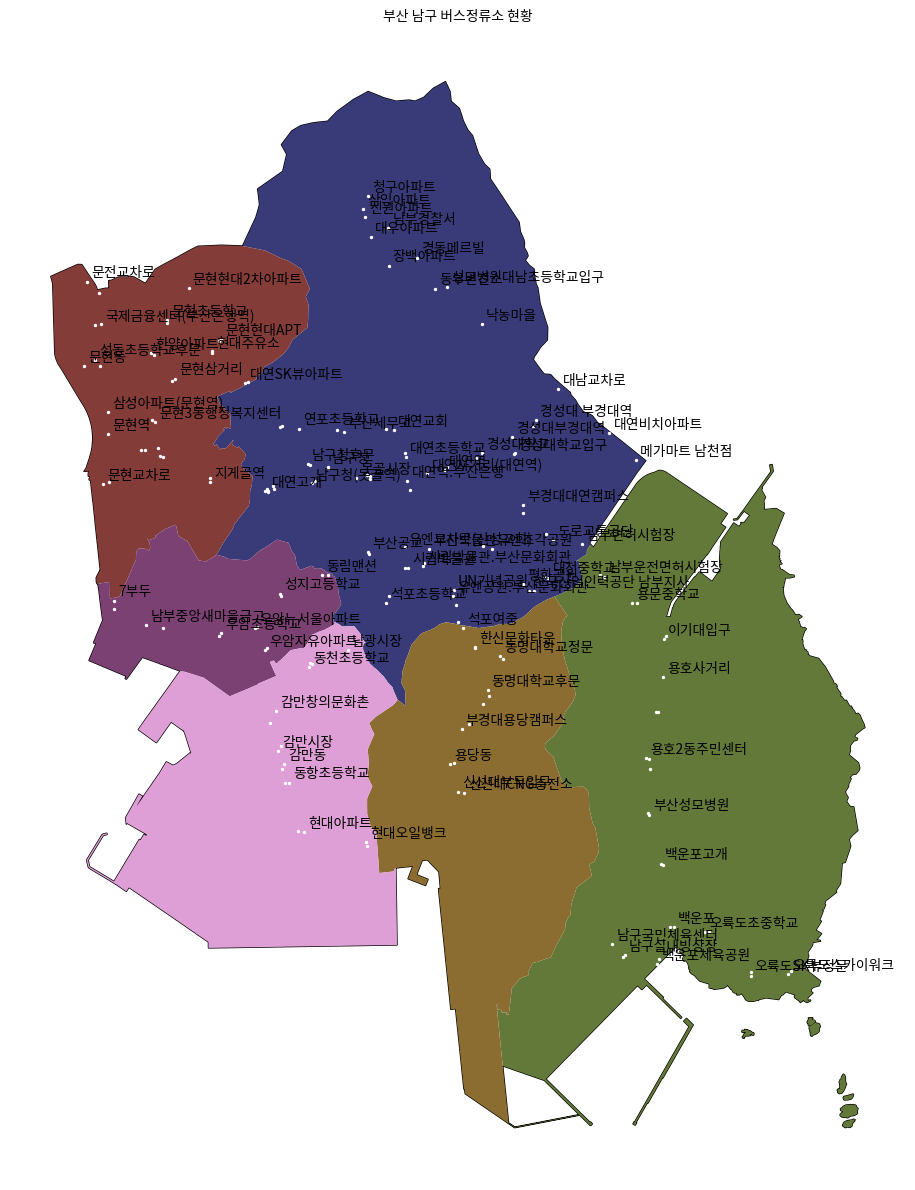

In [52]:
# Plot overlayed maps
fig, ax = plt.subplots(figsize=(12,12))
sig0.plot(color='w', edgecolors='black', ax=ax)
emd0.plot(cmap="tab20b", ax=ax)
geo_df.plot(markersize=2, color='w', ax=ax)

# 데이터에 label을 추가
for x, y, label in zip(unique_df.geometry.x, unique_df.geometry.y, unique_df.stn_nm):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontproperties=fontprop)

ax.set_axis_off()
plt.title('부산 남구 버스정류소 현황', fontproperties=fontprop)
plt.tight_layout()
plt.savefig('overlay_map.png')
plt.show()

## 방법 2. folium 맵 사용하기

### 방법2-1. openstreet 맵사용하기

In [53]:
!pip install -U folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [54]:
df_center = geo_df.loc[geo_df['stn_nm'] == '석포초등학교'][:1]
df_center['lon']

87    129.089865
Name: lon, dtype: float64

In [55]:
import folium

##  지도의 중앙위치 설정
lon = float(df_center['lon'])
lat =  float(df_center['lat'])
center = ( lat, lon ); zoom = 14

# 맵타(tiles) 일에 대한 정보는 다음을 참고
# https://deparkes.co.uk/2016/06/10/folium-map-tiles/
m = folium.Map(location=center, tiles='Stamen Toner', zoom_start=zoom)

In [56]:
# 데이터형 확인
geo_df.dtypes

stn_no       float64
stn_id         int64
stn_nm        object
lon          float64
lat          float64
stn_info      object
geometry    geometry
dtype: object

In [57]:
# 형 변환(CAST 연산)
geo_df[["lon", "lat"]] = geo_df[["lon", "lat"]].apply(pd.to_numeric)

In [58]:
# 데이터 프레임
geo_df.dtypes

stn_no       float64
stn_id         int64
stn_nm        object
lon          float64
lat          float64
stn_info      object
geometry    geometry
dtype: object

In [59]:
# 데이터프레임에 마커를 추가
for index, row in geo_df.iterrows():
   folium.Marker([row['lat'], row['lon']]).add_to(m)

### 방법 2-2. vworld 맵사용하기

vworld 는 국토교통부에서 운영 중인 공간정보 오픈 플랫폼입니다. vworld 지도를 활용하기 위해서는 회원 가입 후, OpenAPI 인증키를 발급 받아야 합니다.

인증키 발급 : http://www.vworld.kr/dev/v4dv_apikey_s001.do

인증키는 회원 가입 시 등록한 이메일 주소로 발송됩니다.
88CB4452-84A2-3D71-AFF6-BEDD2EA4F234

In [62]:
YOUR_API_KEY = '553F9F70-8329-37D4-9FA5-7D5FE28A8631'

In [63]:
m1 = folium.Map(location=center,
           zoom_start=13,
           tiles='http://api.vworld.kr/req/wmts/1.0.0/'+YOUR_API_KEY+'/Base/{z}/{y}/{x}.png',
           attr='My Data Attribution')

# 데이터프레임에 마커를 추가
for index, row in geo_df.iterrows():
    folium.Marker([row['lat'], row['lon']]).add_to(m1)

m1